<a href="https://colab.research.google.com/github/romainvaltier/filecoin_total_raw_eib_power_prediction/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import sys

!{sys.executable} -m pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import warnings
from datetime import datetime
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = [10, 10]

# Get data

In [61]:
# Extract dataset from source: https://dashboard.starboard.ventures/
# Example to get json file: https://observable-api.starboard.ventures/getdata/network-storage-capacity?start=2020-10-14&=&end=2022-06-15

start_date = "2020-10-14"
end_date = "2022-06-16"

df_raw = pd.read_json(
    "https://observable-api.starboard.ventures/getdata/network-storage-capacity?start=" + start_date + "&=&end=" + end_date
)
df_raw = pd.json_normalize(df_raw["data"])
df_raw.head()

,stat_date,total_qa_bytes_power,total_raw_bytes_power
0,2020-10-15T00:00:00.000Z,647290569810247680,647290569810247680
1,2020-10-16T00:00:00.000Z,660145338207698944,660145338207698944
2,2020-10-17T00:00:00.000Z,666643761165500416,666643761165500416
3,2020-10-18T00:00:00.000Z,669327943926808576,669327943926808576
4,2020-10-19T00:00:00.000Z,679868274707529728,679868274707529728


In [62]:
# Copy dataset before transformation
df = df_raw

# Convert stat_date to date
df["date"] = pd.to_datetime(df.stat_date, format="%Y-%m-%dT%H:%M:%S.%fZ")
df = df.set_index("date")
df.index.name = "index"

# Convert storage to PiB and add respective columns
df["total_qa_pib_power"] = (
    pd.to_numeric(df["total_qa_bytes_power"], errors="coerce") / 1024**5
)
df["total_raw_pib_power"] = (
    pd.to_numeric(df["total_raw_bytes_power"], errors="coerce") / 1024**5
)

df["total_qa_eib_power"] = (
    pd.to_numeric(df["total_qa_bytes_power"], errors="coerce") / 1024**6
)
df["total_raw_eib_power"] = (
    pd.to_numeric(df["total_raw_bytes_power"], errors="coerce") / 1024**6
)

df.head()

,stat_date,total_qa_bytes_power,total_raw_bytes_power,total_qa_pib_power,total_raw_pib_power,total_qa_eib_power,total_raw_eib_power
index,,,,,,,
2020-10-15,2020-10-15T00:00:00.000Z,647290569810247680,647290569810247680,574.909515,574.909515,0.561435,0.561435
2020-10-16,2020-10-16T00:00:00.000Z,660145338207698944,660145338207698944,586.326843,586.326843,0.572585,0.572585
2020-10-17,2020-10-17T00:00:00.000Z,666643761165500416,666643761165500416,592.098602,592.098602,0.578221,0.578221
2020-10-18,2020-10-18T00:00:00.000Z,669327943926808576,669327943926808576,594.482635,594.482635,0.580549,0.580549
2020-10-19,2020-10-19T00:00:00.000Z,679868274707529728,679868274707529728,603.844330,603.844330,0.589692,0.589692


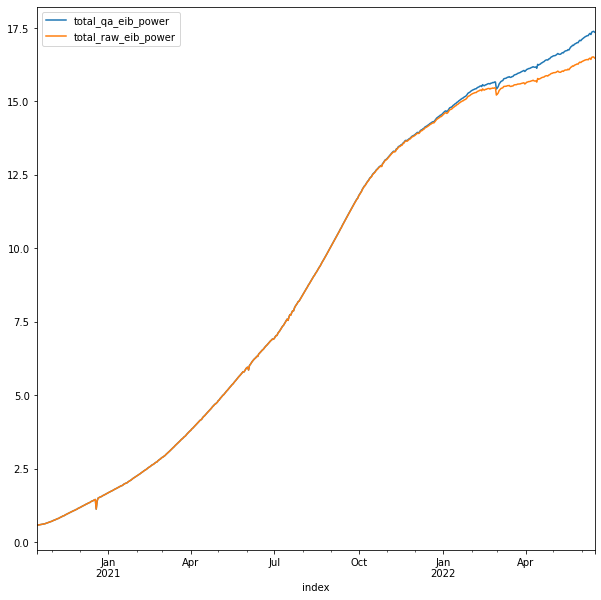

In [63]:
# Disply graphic(s)

df.plot(y=["total_qa_eib_power", "total_raw_eib_power"])

plt.show();

# Analyze and prepare data

In [64]:
df = df["total_raw_eib_power"]
df.size

609

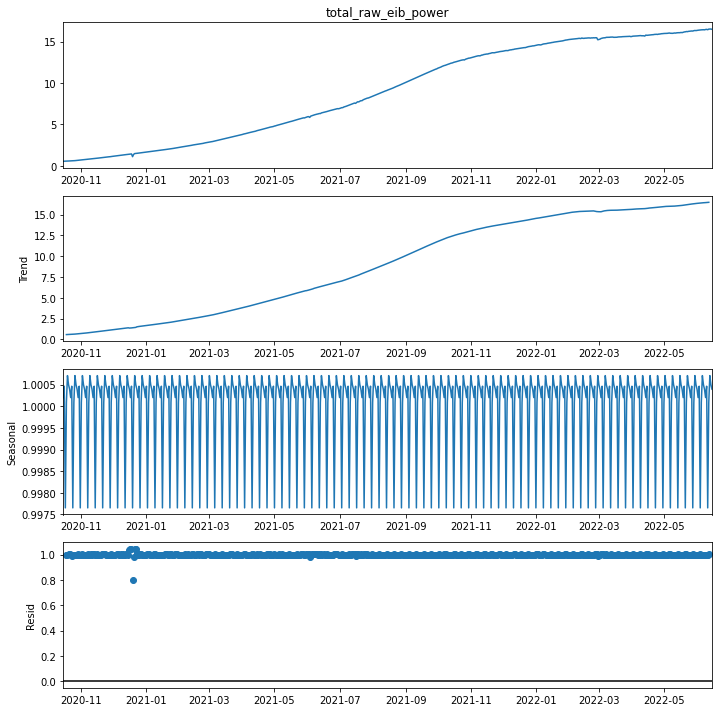

In [65]:
res = seasonal_decompose(df, model="multiplicative")
res.plot()
plt.show();

In [66]:
# Validate hipothesis: not stationnary
_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(df)
p_value  # accepted p-valeur > 5%

0.24532745525818317

In [67]:
# Prepare dataset
dflog = np.log(df)
dflog_1 = dflog.diff().dropna()
dflog_2 = dflog_1.diff(periods=7).dropna()

In [68]:
# Validate hipothesis: not stationnary
_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(dflog_2)
p_value  # rejected p-valeur < 5%

7.168508432241971e-12

# Prepare and train model

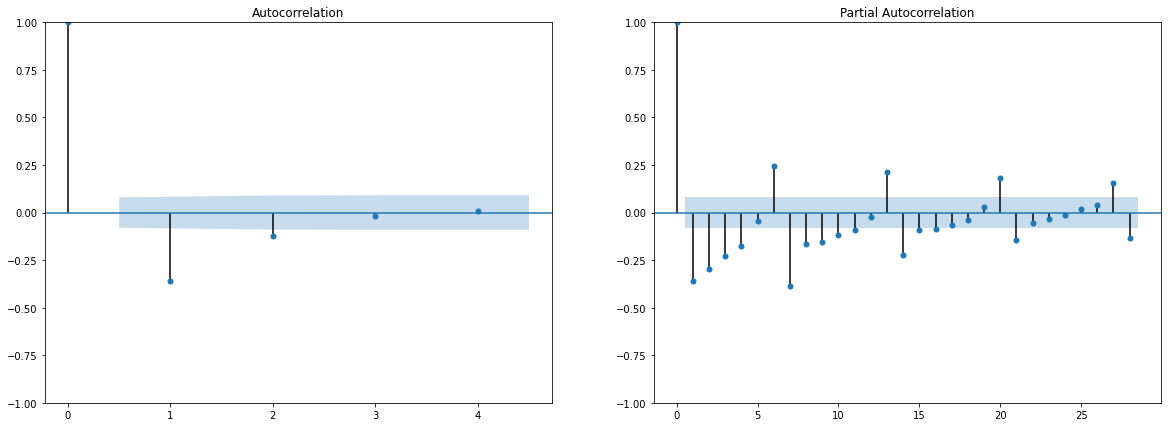

In [69]:
# Check correlation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

plot_acf(dflog_2, lags=4, ax=ax1)  # q,Q => 1
plot_pacf(dflog_2, lags=28, ax=ax2)  # p,P => 7
plt.show();

In [70]:
# Identify best parameters
model_autoarima = auto_arima(dflog, seasonal=True, m=7)
# m = 7 as data contains daily observations
print("ARIMA(",model_autoarima.order,")(",model_autoarima.seasonal_order,")")

ARIMA( (0, 2, 3) )( (0, 0, 0, 7) )


In [71]:
# Train model
model = sm.tsa.SARIMAX(
    dflog, order=model_autoarima.order, seasonal_order=model_autoarima.seasonal_order
)
sarima = model.fit()
print(sarima.summary())

                                SARIMAX Results                                
Dep. Variable:     total_raw_eib_power   No. Observations:                  609
Model:                SARIMAX(0, 2, 3)   Log Likelihood                1800.874
Date:                 Fri, 17 Jun 2022   AIC                          -3593.748
Time:                         09:29:26   BIC                          -3576.114
Sample:                     10-15-2020   HQIC                         -3586.887
                          - 06-15-2022                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5471      0.011   -142.282      0.000      -1.568      -1.526
ma.L2          0.4008      0.018     22.006      0.000       0.365       0.437
ma.L3          0.1714      0.015     11.593 

# Prediction

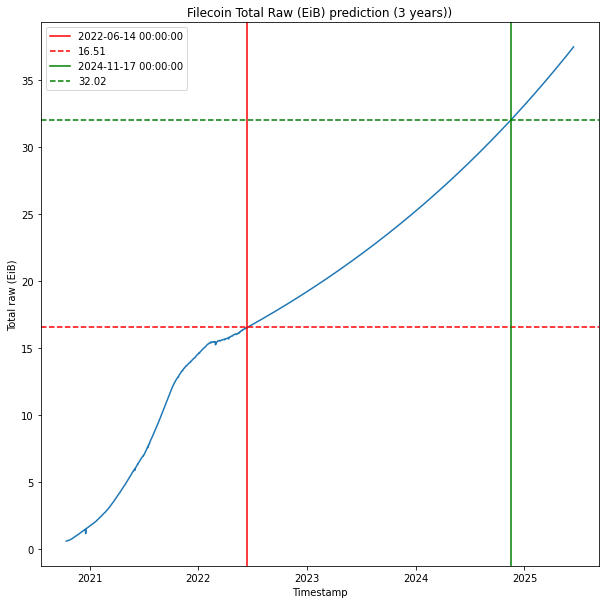

In [72]:
plt = reload(plt)

# Prédiction et passage à l'exponentielle
pred = np.exp(sarima.predict(df.size, df.size + 365 * 3))

# Concaténation des prédictions
dfpred = pd.concat([df, pred])

plt.plot(dfpred)  # Visualisation

plt.axvline(
    x=df[df == df.max()].index.item(),
    color="red",
    label=df[df == df.max()].index.item(),
)
plt.axhline(y=df.max(), color="red", linestyle="dashed", label=round(df.max(), 2))

plt.axvline(
    x=pred[pred.values >= 32].first("D").index.item(),
    color="green",
    label=pred[pred.values >= 32].first("D").index.item(),
)
plt.axhline(
    y=pred[pred.values >= 32].first("D").iloc[0],
    color="green",
    linestyle="dashed",
    label=round(pred[pred.values >= 32].first("D").iloc[0], 2),
)

plt.title("Filecoin Total Raw (EiB) prediction (3 years))")
plt.xlabel("Timestamp")
plt.ylabel("Total raw (EiB)")

plt.legend(loc="best")

plt.savefig("filecoin_total_raw_eib_power_prediction.png")

plt.show();